<a href="https://colab.research.google.com/github/uichann/My_Repository/blob/main/%EB%AA%A8%EA%B7%B8_model_1_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *



In [2]:
data = pd.read_excel("/content/drive/MyDrive/sample_data_MORG.xlsx")

In [3]:
data

,HUMAN ID,성별,나이,키,가슴너비,허리너비,엉덩이너비,가슴두께,허리두께,엉덩이두께,...,배둘레,엉덩이둘레,어깨너비,장딴지둘레,종아리최소둘레,몸무게,골격근량,체지방량,BMI,체지방률
0,120100196,남,7,1330.000000,206.000000,198.000000,239.0,151.0,175.000000,157.0,...,664.000000,727.0,276.0,286.0,181.0,31.6,11.1,9.3,17.9,29.3
1,120100197,남,7,1160.000000,179.000000,148.000000,198.0,128.0,118.000000,125.0,...,498.000000,572.0,235.0,233.0,150.0,19.4,8.3,2.5,14.4,12.7
2,120100198,남,7,1243.000000,208.000000,195.000000,216.0,129.0,130.000000,146.0,...,557.000000,627.0,286.0,265.0,161.0,23.6,9.6,3.8,15.4,16.3
3,120100199,남,7,1144.000000,206.000000,173.000000,200.0,126.0,130.000000,145.0,...,507.000000,602.0,260.0,239.0,160.0,19.9,7.3,4.0,15.3,20.2
4,120100200,남,7,1277.000000,235.930615,238.363337,255.0,142.0,195.000000,182.0,...,743.846722,770.0,310.0,308.0,199.0,37.1,12.4,12.7,22.7,34.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871,220105675,여,13,1632.000000,252.000000,215.000000,320.0,161.0,160.000000,207.0,...,782.000000,916.0,335.0,335.0,212.0,52.1,21.3,12.6,19.6,24.2
4872,220105676,여,13,1394.498785,214.000000,196.000000,253.0,147.0,133.000000,164.0,...,629.000000,728.0,296.0,261.0,182.0,30.1,12.0,6.3,15.6,20.9
4873,220105677,여,13,1527.000000,242.000000,222.000000,304.0,180.0,161.000000,195.0,...,724.000000,844.0,335.0,341.0,209.0,48.0,18.3,13.4,20.5,27.9
4874,220105678,여,13,1457.000000,217.000000,206.000000,268.0,157.0,153.382488,257.0,...,652.000000,748.0,315.0,286.0,194.0,34.6,14.2,6.9,16.2,19.9


In [4]:
data = data[['성별','나이','키','몸무게','가슴너비','허리너비','엉덩이너비','어깨너비','BMI','가슴둘레','허리둘레','종아리최소둘레','엉덩이둘레','체지방률']].reset_index(drop = True)



In [5]:
data.columns = ['Sex','Age','Heigt','weight','Chest_wid','waist_wid','hip_wid','shoul_wid','BMI','bust','waist_cir','calf_cir','hip_cir','body_fat']

In [6]:
data['Sex'] = data['Sex'].map({'남': 1, '여': 0})

In [7]:
data.dropna(inplace=True)

In [8]:
data.isnull().sum()

Sex          0
Age          0
Heigt        0
weight       0
Chest_wid    0
waist_wid    0
hip_wid      0
shoul_wid    0
BMI          0
bust         0
waist_cir    0
calf_cir     0
hip_cir      0
body_fat     0
dtype: int64

In [9]:
Q1 = data[['Sex','Age','Heigt','weight','Chest_wid','waist_wid','hip_wid','shoul_wid','BMI','bust','waist_cir','calf_cir','hip_cir','body_fat']].quantile(q=0.25)
Q3 = data[['Sex','Age','Heigt','weight','Chest_wid','waist_wid','hip_wid','shoul_wid','BMI','bust','waist_cir','calf_cir','hip_cir','body_fat']].quantile(q=0.75)


In [11]:
IQR = Q3-Q1

In [12]:
#이상치 제거
IQR_df = data[(data['Sex'] <= Q3['Sex']+1.5*IQR['Sex']) & (data['Sex'] >= Q1['Sex']-1.5*IQR['Sex'])]
IQR_df = IQR_df[(IQR_df['Age'] <= Q3['Age']+1.5*IQR['Age']) & (IQR_df['Age'] >= Q1['Age']-1.5*IQR['Age'])]
IQR_df = IQR_df[(IQR_df['Heigt'] <= Q3['Heigt']+1.5*IQR['Heigt']) & (IQR_df['Heigt'] >= Q1['Heigt']-1.5*IQR['Heigt'])]
IQR_df = IQR_df[(IQR_df['weight'] <= Q3['weight']+1.5*IQR['weight']) & (IQR_df['weight'] >= Q1['weight']-1.5*IQR['weight'])]
IQR_df = IQR_df[(IQR_df['Chest_wid'] <= Q3['Chest_wid']+1.5*IQR['Chest_wid']) & (IQR_df['Chest_wid'] >= Q1['Chest_wid']-1.5*IQR['Chest_wid'])]
IQR_df = IQR_df[(IQR_df['waist_wid'] <= Q3['waist_wid']+1.5*IQR['waist_wid']) & (IQR_df['waist_wid'] >= Q1['waist_wid']-1.5*IQR['waist_wid'])]
IQR_df = IQR_df[(IQR_df['hip_wid'] <= Q3['hip_wid']+1.5*IQR['hip_wid']) & (IQR_df['hip_wid'] >= Q1['hip_wid']-1.5*IQR['hip_wid'])]
IQR_df = IQR_df[(IQR_df['shoul_wid'] <= Q3['shoul_wid']+1.5*IQR['shoul_wid']) & (IQR_df['shoul_wid'] >= Q1['shoul_wid']-1.5*IQR['shoul_wid'])]
IQR_df = IQR_df[(IQR_df['bust'] <= Q3['bust']+1.5*IQR['bust']) & (IQR_df['bust'] >= Q1['bust']-1.5*IQR['bust'])]
IQR_df = IQR_df[(IQR_df['waist_cir'] <= Q3['waist_cir']+1.5*IQR['waist_cir']) & (IQR_df['waist_cir'] >= Q1['waist_cir']-1.5*IQR['waist_cir'])]
IQR_df = IQR_df[(IQR_df['calf_cir'] <= Q3['calf_cir']+1.5*IQR['calf_cir']) & (IQR_df['calf_cir'] >= Q1['calf_cir']-1.5*IQR['calf_cir'])]
IQR_df = IQR_df[(IQR_df['hip_cir'] <= Q3['hip_cir']+1.5*IQR['hip_cir']) & (IQR_df['hip_cir'] >= Q1['hip_cir']-1.5*IQR['hip_cir'])]
IQR_df = IQR_df[(IQR_df['body_fat'] <= Q3['body_fat']+1.5*IQR['body_fat']) & (IQR_df['body_fat'] >= Q1['body_fat']-1.5*IQR['body_fat'])]

IQR_df = IQR_df[['Sex','Age','Heigt','weight','Chest_wid','waist_wid','hip_wid','shoul_wid','BMI','bust','waist_cir','calf_cir','hip_cir','body_fat']]

print('original_df :', len(data))
print('IQR_df :', len(IQR_df))

data=IQR_df

original_df : 4270
IQR_df : 4159


In [13]:
data['body_fat'] = data['body_fat'].round()

In [14]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.5 MB/s 


In [15]:
import numpy as np
import os, matplotlib
from matplotlib import pyplot as plt

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
import tensorflow_addons as tfa

In [16]:
data.drop(columns=['Sex','Age','shoul_wid'],axis=1,inplace=True)

In [17]:
x = data.drop(['body_fat'],axis=1).values
y = data['body_fat'].values

In [18]:
x

array([[1330. ,   31.6,  206. , ...,  624. ,  181. ,  727. ],
       [1160. ,   19.4,  179. , ...,  498. ,  150. ,  572. ],
       [1243. ,   23.6,  208. , ...,  543. ,  161. ,  627. ],
       ...,
       [1527. ,   48. ,  242. , ...,  662. ,  209. ,  844. ],
       [1457. ,   34.6,  217. , ...,  600. ,  194. ,  748. ],
       [1565. ,   40.1,  248. , ...,  609. ,  208. ,  785. ]])

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
x_train.shape

(3327, 10)

In [23]:
y_train.shape

(3327,)

In [24]:
y_test.shape

(832,)

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [26]:
#scalerX = StandardScaler()
#scalerY = StandardScaler()
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()
x_train_scaled = scalerX.fit_transform(x_train)
x_test_scaled = scalerX.transform(x_test)

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[10]),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
     layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(0.0025), loss=keras.losses.Huber())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [29]:
history = model.fit(x_train_scaled, y_train, epochs=80,batch_size=40, validation_data=(x_test_scaled, y_test))

Epoch 1/80
84/84 [==============================] - 4s 6ms/step - loss: 8.5833 - val_loss: 3.5473
Epoch 2/80
84/84 [==============================] - 0s 4ms/step - loss: 5.0618 - val_loss: 4.2607
Epoch 3/80
84/84 [==============================] - 0s 4ms/step - loss: 4.5018 - val_loss: 3.3914
Epoch 4/80
84/84 [==============================] - 0s 4ms/step - loss: 4.2480 - val_loss: 2.6117
Epoch 5/80
84/84 [==============================] - 1s 6ms/step - loss: 4.2012 - val_loss: 2.6357
Epoch 6/80
84/84 [==============================] - 1s 8ms/step - loss: 4.0814 - val_loss: 2.7311
Epoch 7/80
84/84 [==============================] - 1s 7ms/step - loss: 3.8513 - val_loss: 2.5105
Epoch 8/80
84/84 [==============================] - 0s 4ms/step - loss: 3.8611 - val_loss: 2.6867
Epoch 9/80
84/84 [==============================] - 0s 4ms/step - loss: 3.8614 - val_loss: 2.6020
Epoch 10/80
84/84 [==============================] - 0s 4ms/step - loss: 3.9494 - val_loss: 2.5752
Epoch 11/80
84/84 [

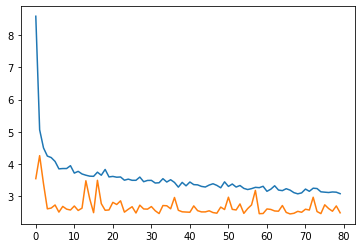

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [31]:
test_predictions = model(x_test_scaled).numpy()
train_predictions = model(x_train_scaled).numpy()

In [32]:
train_predictions

array([[18.613073],
       [23.77797 ],
       [29.952362],
       ...,
       [21.011086],
       [22.859499],
       [20.038305]], dtype=float32)

In [33]:
mean_squared_error(test_predictions, y_test, squared=False)

3.9041297990991115

In [34]:
r2 = tfa.metrics.r_square.RSquare()
r2.update_state(y_test, test_predictions.reshape(-1))
print(f'Test Set R2: {r2.result().numpy()}')
r2.update_state(y_train, train_predictions.reshape(-1))
print(f'Test Set R2: {r2.result().numpy()}')

Test Set R2: 0.7082490921020508
Test Set R2: 0.7359796762466431
